<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» по модерации комментариев

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#импортируем библиотеки
import os
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

In [2]:
#считаем файл с данными и сохраним в датафрейм

pth1 = 'C:/Users/ACER/Desktop/Практикум/project/datasets/toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'


if os.path.exists(pth1):
    data = pd.read_csv(pth1)
else:
    data = pd.read_csv(pth2)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data = data.drop('Unnamed: 0', axis=1)

In [6]:
data.duplicated().sum()

0

In [7]:
#посмотрим распределение классов в целевом признаке

data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

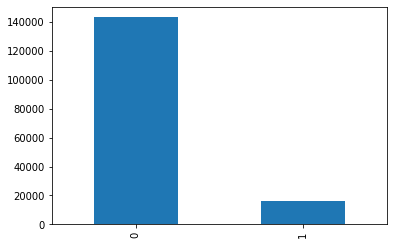

In [8]:
data['toxic'].value_counts().plot(kind='bar')
plt.show()

In [9]:
#очистим и лемматизируем текст в столбце `text`

def clear_text(text):
    text_clear = text.lower()
    text_clear = re.sub(r'[^a-zA-Z]', ' ', text_clear)
    text_clear = text_clear.split()
    return " ".join(text_clear)

data['text'] = data['text'].apply(clear_text)

data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


In [10]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {'J': wordnet.ADJ,
                'N': wordnet.NOUN,
                'V': wordnet.VERB,
                'R': wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    lemm_list = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(lemm_list)

data['text'] = data['text'].apply(lemmatize)


data.head()

,text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


In [11]:
#поделим датасет на обучающую, валидационную и тестовую выборки

features = data.drop('toxic', axis=1)

target = data['toxic']

X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42, stratify=y_valid)

for i in [X_train, y_train, X_valid, y_valid, X_test, y_test]:
    print(i.shape)

(127433, 1)
(127433,)
(15929, 1)
(15929,)
(15930, 1)
(15930,)


In [12]:
#увеличим обучающую выборку, продублировав объекты положительного класса

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    X_train_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    y_train_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    X_train_upsampled, y_train_upsampled = shuffle(
        X_train_upsampled, y_train_upsampled, random_state=42)
    
    return X_train_upsampled, y_train_upsampled

X_train_upsampled, y_train_upsampled = upsample(X_train, y_train, 9)

__Вывод__

Данные соответствуют описанию, пропуски и дубликаты в строках отсутствуют. В целевом признаке имеется дисбаланс, обучение будет проводится на данных с балансировкой, а также на увеличенной обучающей выборке. Столбец `Unnamed: 0` удален как излишняя информация. Текст комментариев очищен и лемматизирован, преобразован в векторы. Целевой признак представлен классами - позитивные/негативные комментарии, будем решать задачу классификации с учителем. Данные поделены на обучающую, валидационную и тестовую выборки в соотношении 80/10/10.

## Обучение

In [13]:
pipeline = Pipeline(
    [
        ('vect', TfidfVectorizer(stop_words='english')),
        ('clf', LogisticRegression(random_state=42)),
    ]
)

In [14]:
#определим параметры для GridSearchCV

parameters_lr_bal = {'clf__solver': ('liblinear', 'saga'),
                     'clf__C': (.1, 5),
                     'clf__max_iter': [300],
                     'clf__class_weight':['balanced']}

parameters_lr = {'clf__solver': ('liblinear', 'saga'),
                 'clf__C': (.1, 5),
                 'clf__max_iter': [300]}
              
parameters_cb = {'depth': [5],
                 'learning_rate' : [0.05, 1],
                 'iterations': [100]}

### LogisticRegression

In [15]:
#обучим модель с балансировкой данных

grid_lr_balance = GridSearchCV(pipeline, parameters_lr_bal, cv = 3, scoring='f1')

grid_lr_balance.fit(X_train.text, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             param_grid={'clf__C': (0.1, 5), 'clf__class_weight': ['balanced'],
                         'clf__max_iter': [300],
                         'clf__solver': ('liblinear', 'saga')},
             scoring='f1')

In [16]:
grid_lr_balance.best_estimator_

Pipeline(steps=[('vect', TfidfVectorizer(stop_words='english')),
                ('clf',
                 LogisticRegression(C=5, class_weight='balanced', max_iter=300,
                                    random_state=42, solver='liblinear'))])

In [17]:
f1_lr_balance = grid_lr_balance.best_score_

print('f1 на обучающей выборке с балансировкой:', f1_lr_balance)

f1 на обучающей выборке с балансировкой: 0.7530892292791208


In [18]:
#проверим модель на тестовой выборке

predict_test = grid_lr_balance.best_estimator_.predict(X_test.text)

f1_test_lr = f1_score(y_test, predict_test)

print('f1 на тестовой выборке:', f1_test_lr)

f1 на тестовой выборке: 0.7527612574341547


In [19]:
#обучим модель на увеличенной обучающей выборке

grid_lr_upsampled = GridSearchCV(pipeline, parameters_lr, cv = 3, scoring='f1')

grid_lr_upsampled.fit(X_train_upsampled.text, y_train_upsampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             param_grid={'clf__C': (0.1, 5), 'clf__max_iter': [300],
                         'clf__solver': ('liblinear', 'saga')},
             scoring='f1')

In [20]:
#проверим модель на несбалансированной валидационой выборке

predict_test = grid_lr_upsampled.best_estimator_.predict(X_valid.text)

f1_lr_upsampled = f1_score(y_valid, predict_test)

print('f1 на тестовой выборке:', f1_lr_upsampled)

f1 на тестовой выборке: 0.755720823798627


In [21]:
grid_lr_upsampled.best_estimator_

Pipeline(steps=[('vect', TfidfVectorizer(stop_words='english')),
                ('clf',
                 LogisticRegression(C=5, max_iter=300, random_state=42,
                                    solver='liblinear'))])

In [22]:
#проверим модель на тестовой выборке

predict_test_up = grid_lr_upsampled.best_estimator_.predict(X_test.text)

f1_test_lr_up = f1_score(y_test, predict_test_up)

print('f1 на тестовой выборке:', f1_test_lr_up)

f1 на тестовой выборке: 0.7488532110091743


### CatBoostClassifier

In [23]:
model_cb = CatBoostClassifier(random_state=42, auto_class_weights = 'Balanced', text_features=['text'])
grid_cb = GridSearchCV(model_cb, parameters_cb, cv = 3, scoring='f1')
grid_cb.fit(X_train, y_train)
f1_cb = grid_cb.best_score_
print('f1 CatBoostRegressor() на обучающей выборке:', f1_cb)

0:	learn: 0.6678924	total: 357ms	remaining: 35.3s
1:	learn: 0.6440933	total: 634ms	remaining: 31.1s
2:	learn: 0.6219871	total: 934ms	remaining: 30.2s
3:	learn: 0.6014199	total: 1.23s	remaining: 29.4s
4:	learn: 0.5822145	total: 1.54s	remaining: 29.3s
5:	learn: 0.5657750	total: 1.82s	remaining: 28.6s
6:	learn: 0.5507639	total: 2.1s	remaining: 27.9s
7:	learn: 0.5367900	total: 2.37s	remaining: 27.3s
8:	learn: 0.5242571	total: 2.66s	remaining: 26.9s
9:	learn: 0.5108321	total: 2.94s	remaining: 26.5s
10:	learn: 0.4990743	total: 3.25s	remaining: 26.3s
11:	learn: 0.4886010	total: 3.56s	remaining: 26.1s
12:	learn: 0.4778707	total: 3.85s	remaining: 25.7s
13:	learn: 0.4689932	total: 4.12s	remaining: 25.3s
14:	learn: 0.4596923	total: 4.4s	remaining: 25s
15:	learn: 0.4513198	total: 4.7s	remaining: 24.7s
16:	learn: 0.4429029	total: 4.97s	remaining: 24.2s
17:	learn: 0.4353880	total: 5.26s	remaining: 24s
18:	learn: 0.4281845	total: 5.55s	remaining: 23.7s
19:	learn: 0.4214674	total: 5.88s	remaining: 23.

In [24]:
#проверим модель на тестовой выборке

predict_test_cb = grid_cb.best_estimator_.predict(X_test)

f1_test_cb = f1_score(y_test, predict_test_cb)

print('f1 на тестовой выборке:', f1_test_cb)

f1 на тестовой выборке: 0.7072336265884653


In [25]:
#создадим DataFrame со сводными результатами по обучению моделей

results = pd.DataFrame({'Model': ['LogisticRegression с балансировкой', 'LogisticRegression на увеличенной выборке',
                                  'CatBoostRegressor с балансировкой'],
                        'f1-мера на обучающей/валидационной выборке': [f1_lr_balance, f1_lr_upsampled, f1_cb],
                        'f1-мера на тестовой выборке' : [f1_test_lr, f1_test_lr_up, f1_test_cb]})
results.set_index('Model')

,f1-мера на обучающей/валидационной выборке,f1-мера на тестовой выборке
Model,,
LogisticRegression с балансировкой,0.753089,0.752761
LogisticRegression на увеличенной выборке,0.755721,0.748853
CatBoostRegressor с балансировкой,0.684736,0.707234


__Вывод__

Данные обучены на двух моделях с использованием разных гиперпараметров - LogisticRegression, CatBoostRegressor. Лучшее значение метрики F1 на обучающей выборке у модели LogisticRegression, обученной на данных со сбалансированными классами.

## Выводы

На основании набора данных с разметкой о токсичности правок обучена модель, позволяющая классифицировать комментарии на позитивные и негативные. 

Данные соответствуют описанию, пропуски и дубликаты в строках отсутствуют. В целевом признаке имеется дисбаланс, обучение проводится на данных с балансировкой, а также на увеличенной обучающей выборке. Текст комментариев очищен и лемматизирован, преобразован в векторы. Целевой признак представлен классами - позитивные/негативные комментарии, решаем задачу классификации с учителем. Данные поделены на обучающую? валидационную и тестовую выборки в соотношении 80/10/10.

Данные обучены на двух моделях с использованием разных гиперпараметров - LogisticRegression, CatBoostRegressor. Лучшее значение метрики F1 на обучающей выборке у модели LogisticRegression, обученной на данных со сбалансированными классами.
Целевой показатель метрики качества модели *F1* не меньше 0.75 на тестовой выборке достигнут.